# Single pulsar noise analysis
- In this notebook, we're going to explore how to determine the intrinsic noise properties of pulsars!

## Why do we want to do this?
- After solving a pulsar timing model, there will be leftover signals in the data.
- Some of these processes are systematic (time-uncorrelated white noise) and some are astrophysical (time-correlated red noise).
- Understanding these signals gives us information about the pulsar and the IISM.
- Modelling these signals out of the data gives us more precise measurements of the pulsar timing model parameters (i.e. pulsar and companion masses, positions, distances, etc...)
- It's fun!
- (Fun not guaranteed)

### Load the modules we need

In [1]:
import numpy as np
import pickle
import json
import glob
import os

import matplotlib.pyplot as plt

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
from enterprise.signals import gp_bases
import enterprise.constants as const
from enterprise_extensions.chromatic.solar_wind import solar_wind, createfourierdesignmatrix_solar_dm
import enterprise_extensions
from enterprise_extensions import models, model_utils, hypermodel, blocks
from enterprise_extensions import timing
from enterprise_extensions.frequentist import optimal_statistic as opt_stat
import time
import h5py
import dill

import libstempo as T
import libstempo.plot as LP, libstempo.toasim as LT


Do not have mpi4py package.


In [2]:
# Choose your pulsar {J0900-3144, J1045-4509, J1431-5740, J2234+0944}
datadir = "./SP_data/"

psrname = "J0900-3144"

### First step: Load and inspect the data

/var/folders/0d/3n4fgnc56j18ryg6n7s9jw341mfmjs/T/ipykernel_39570/3020133515.py:1: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.


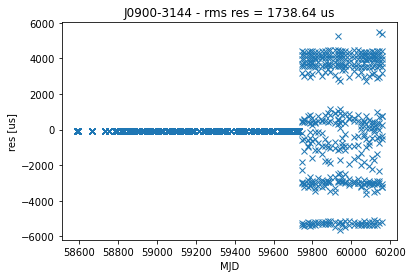

In [3]:
psr = T.tempopulsar(parfile = datadir+psrname+'.par',
                    timfile = datadir+psrname+'.tim')
LP.plotres(psr)

### There is definitely structure! But what is it?

- If the changes look sharp rather than smooth, that might be an indication of frequency dependent variations.

- Or maybe it's spin noise from irregularities in the rotation of the pulsar?

- Where does the uncorrelated noise come in? What needs to be checked there?

### We don't know what's important yet, so let's find out
- The most robust way to do this is by using Bayesian analysis techniques to compare different models, identifying the one that the data favours the most.
- The modern way to do this is through the use of the Enterprise (https://github.com/nanograv/enterprise) pulsar timing Bayesian analysis software developed by NANOGrav.

### Second step: Build a white noise model

The white (uncorrelated) noise and the red (correlated) noise are different enough that you can separate this analysis - usually.

It is common practice is to first establish a white noise model, which directly alters the uncertainties of the pulse arrival times, and then hold these fixed at their maximum likelihood (or maximum a-posteriori) values when searching for red noise.

Performing the analysis in this way, rather than all at once, saves considerable computational effort.

The white noise model can be described by: $\sigma_{\mathrm{TOA}} = \sqrt{(\mathrm{EFAC} \times \sigma_{\mathrm{obs}})^{2} + \mathrm{EQUAD}^{2}}$

Generally, these are added to the observing systems and bands as they are thought to stem from systematic errors in the timing process that are connected to these systems. For the data we're using, we only have a single observing system and band so we just assign it to the backend used to record the arrival time.

Let's set these prior spaces up below:

In [4]:
selection = selections.Selection(selections.by_backend)


efac = parameter.Uniform(0.1, 10)
equad = parameter.Uniform(-10, -5)

wn = white_signals.MeasurementNoise(efac=efac, log10_t2equad=equad, selection=selection)

The pulsar may also have another white noise parameter known as ECORR. This accounts for what is known as jitter noise, arising from the stochastic variance in morphology and phase of each individual pulse from the pulsar. 

This parameter is applied in the same manner as EQUAD, but is one that is completely correlated between arrival times in a single epoch, but uncorrelated between arrival times in other epochs. This can either be applied to the uncertainties as part of the white noise matrix, or as a Gaussian process. For simplicity, we add this as a Gaussian process below:


In [5]:
ecorr = parameter.Uniform(-10,-1) 
wn += gp_signals.EcorrBasisModel(log10_ecorr=ecorr, selection=selection)

We now have a white noise model!

The next thing to do is to take into account timing model. This is done by marginalising over the timing model parameters rather than simultaneously searching over them as they are unlikely to be very covariant.

In [6]:
tm = gp_signals.MarginalizingTimingModel(use_svd=True)

These are then added together as an Enterprise signal object defining the model:

In [7]:
s = tm + wn

In [8]:
type(s)

enterprise.signals.signal_base.MetaCollection

Suddenly we have a signal model that we can sample and start our first foray into signal modelling in pulsar data! To investigate this we'll use a parallel-tempered markov chain Monte Carlo (PTMCMC) product space sampler that is built into Enterprise. Let's set it up:

In [9]:
# Set up an enterprise pulsar object
epsr = Pulsar(datadir+psrname+'.par', datadir+psrname+'.tim', ephemeris='DE440')

In [10]:
# Set up a pta object using the signal object on the pulsar 
pta = signal_base.PTA(s(epsr))

In [11]:
# Print the summary and check it all looks good
print(pta.summary())

enterprise v3.3.1,  Python v3.9.12

Signal Name                              Signal Class                   no. Parameters      
J0900-3144_marginalizing_linear_timing_model TimingModel                    0                   

params:
__________________________________________________________________________________________
J0900-3144_measurement_noise             MeasurementNoise               2                   

params:
J0900-3144_KAT_MKBF_efac:Uniform(pmin=0.1, pmax=10)                                       
J0900-3144_KAT_MKBF_log10_t2equad:Uniform(pmin=-10, pmax=-5)                              
__________________________________________________________________________________________
J0900-3144_basis_ecorr                   EcorrBasisModel                1                   

params:
J0900-3144_basis_ecorr_KAT_MKBF_log10_ecorr:Uniform(pmin=-10, pmax=-1)                    
__________________________________________________________________________________________
Total params: 3

#### The hypermodel framework allows different models (i.e. different correlated signals) to be compared!
- Here we only use it to assess a single model. For many models, add them to the pta_dict below and we can compare them:

In [12]:
pta_dict = dict.fromkeys(np.arange(1))
pta_dict[0] = pta

In [13]:
hyper_model = hypermodel.HyperModel(pta_dict)
x0 = hyper_model.initial_sample()
ndim = len(x0)

#Choose a number of samples (we would normally use more)
N = int(1e5)

In [14]:
#Make a directory for the results
model_label = "SP_WN_{0}".format(psrname)
outDir = "./results_dir/{0}".format(model_label)
try:
    os.mkdir(outDir)
    print("Made directory")
except:
    print("Already there")
    pass


Already there


In [15]:
sampler = hyper_model.setup_sampler(outdir=outDir, resume=True)

Adding nmodel uniform distribution draws...



/Users/dreardon/opt/anaconda3/envs/ent15y/lib/python3.9/site-packages/numpy/lib/arraysetops.py:272: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


#### Now we sample!
- Should take ~ 2 minutes

In [16]:
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Resuming run from chain file ./results_dir/SP_WN_J0900-3144/chain_1.txt
Adding DE jump with weight 50
Finished 20.00 percent in 8.387257 s Acceptance rate = 0.494355

/Users/dreardon/opt/anaconda3/envs/ent15y/lib/python3.9/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log


Finished 21.00 percent in 11.076844 s Acceptance rate = 0.470815

AttributeError: module 'acor' has no attribute 'acor'

##### Done!

Let's take a look at the results:

In [ ]:
chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))
burn = int(0.25 * chain.shape[0])
efac_ind = list(pta.param_names).index('{0}_KAT_MKBF_efac'.format(psrname))
equad_ind = list(pta.param_names).index('{0}_KAT_MKBF_log10_t2equad'.format(psrname))
ecorr_ind = list(pta.param_names).index('{0}_basis_ecorr_KAT_MKBF_log10_ecorr'.format(psrname))

In [ ]:
med_efac = np.median(chain[burn:, efac_ind])

plt.title("{0} EFAC: {1:.2f}".format(psrname, np.median(chain[burn:, efac_ind])))
plt.plot(chain[burn:, efac_ind])
plt.figure()
plt.hist(chain[burn:,efac_ind], 100, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5)
plt.xlabel('EFAC')
plt.ylabel('PDF')


In [ ]:
med_equad = np.median(chain[burn:, equad_ind])
plt.title("{0} EQUAD: {1:.2f}".format(psrname, np.median(chain[burn:, equad_ind])))
plt.plot(chain[burn:, equad_ind])
plt.figure()
plt.hist(chain[burn:,equad_ind], 100, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5)
plt.xlabel('EQUAD')
plt.ylabel('PDF')

In [ ]:
med_ecorr = np.median(chain[burn:, ecorr_ind])
plt.title("{0} ECORR: {1:.2f}".format(psrname, np.median(chain[burn:, ecorr_ind])))
plt.plot(chain[burn:, ecorr_ind])
plt.figure()
plt.hist(chain[burn:,ecorr_ind], 100, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5)
plt.xlabel('ECORR')
plt.ylabel('PDF')

Nice! We have constraints! Do any look unconstrained? Why do you think that is?

We're now going to put these into a parameter dictionary and start looking for correlated noise processes:

In [ ]:
efac_name = '{0}_KAT_MKBF_efac'.format(psrname)
equad_name = '{0}_KAT_MKBF_log10_t2equad'.format(psrname)
ecorr_name = '{0}_basis_ecorr_KAT_MKBF_log10_ecorr'.format(psrname)

params = {
    efac_name: med_efac,
    equad_name: med_equad,
    ecorr_name: med_ecorr
}

In [ ]:
params

Now we want to search for some red noise terms. 

We define these in general forms expressed as power-law power spectral densities, modelled over the observation span of the pulsar as below:

In [ ]:

tmin = epsr.toas.min()
tmax = epsr.toas.max()
Tspan = np.max(tmax) - np.min(tmin)

# DM Noise function
def dm_noise(log10_A,gamma,Tspan,components=30,option="powerlaw"):
    """
    A term to account for stochastic variations in DM. It is based on spin
    noise model, with Fourier amplitudes depending on radio frequency nu
    as ~ 1/nu^2.
    """
    nfreqs = 30
    if option=="powerlaw":
      pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)

    dm_basis = utils.createfourierdesignmatrix_dm(nmodes = components,
                                                  Tspan=Tspan)
    dmn = gp_signals.BasisGP(pl, dm_basis, name='dm_gp')

    return dmn

#Red Noise model
log10_A_red = parameter.Uniform(-20, -11)
gamma_red = parameter.Uniform(0, 7)
pl = utils.powerlaw(log10_A=log10_A_red, gamma=gamma_red)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)


#DM Noise model
log10_A_dm = parameter.Uniform(-20, -11)
gamma_dm = parameter.Uniform(0, 7)
dm = dm_noise(log10_A=log10_A_dm,gamma=gamma_dm,Tspan=Tspan,components=30,option="powerlaw")

#Chromatic (scattering) Noise model
log10_A_chrom_prior = parameter.Uniform(-20, -11)
gamma_chrom_prior = parameter.Uniform(0, 7)
chrom_gp_idx = parameter.Constant(4)
chrom_model = utils.powerlaw(log10_A=log10_A_chrom_prior, gamma=gamma_chrom_prior)
idx = chrom_gp_idx
chrom_basis = gp_bases.createfourierdesignmatrix_chromatic(nmodes=30,
                                                        idx=idx)
chrom = gp_signals.BasisGP(chrom_model, chrom_basis, name='chrom_gp')



Now we're going to redefine our white noise model so it uses constant parameters that we found previously:

In [ ]:

efac = parameter.Constant()
equad = parameter.Constant()

wn = white_signals.MeasurementNoise(efac=efac, log10_t2equad=equad, selection=selection)

ecorr = parameter.Constant()
wn += gp_signals.EcorrBasisModel(log10_ecorr=ecorr, selection=selection)

s = tm + wn

Now, we need to choose which red noise terms to test over. 

Which do you think are in the pulsar? Every model that's added will increase the time it takes to sample the signal object

In [ ]:
s += rn

In [ ]:
pta = signal_base.PTA(s(epsr))

#Initialise the constant white noise parameters
pta.set_default_params(params)

In [ ]:
# Check the model!
print(pta.summary())

Great! Now that's done and you have constant white noise parameters and varying red noise parameters, go ahead and sample!

In [ ]:
pta_dict = dict.fromkeys(np.arange(1))
pta_dict[0] = pta

hyper_model = hypermodel.HyperModel(pta_dict)
x0 = hyper_model.initial_sample()
ndim = len(x0)

#Choose a number of samples (we would normally use more)
N = int(1e5)

#Make a directory for the results (change the model label to whatever you'd like!)
model_label = "SP_RN_{0}".format(psrname)
outDir = "./results_dir/{0}".format(model_label)
try:
    os.mkdir(outDir)
    print("Made directory")
except:
    print("Already there")
    pass

sampler = hyper_model.setup_sampler(outdir=outDir, resume=True)


In [ ]:
# Sample!
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

In [ ]:
print(pta.param_names)

Grab the names from the parameters above and see how they converged:

In [ ]:
chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))
burn = int(0.25 * chain.shape[0])
param_1_ind = list(pta.param_names).index(pta.param_names[0])
param_2_ind = list(pta.param_names).index(pta.param_names[1])
#param_etc_ind = list(pta.param_names).index(pta.param_names[2])

In [ ]:
med_param_1 = np.median(chain[burn:, param_1_ind])
plt.title("{0} {1}: {2:.2f}".format(psrname, pta.param_names[0], med_param_1))
plt.plot(chain[burn:, param_1_ind])
plt.figure()
plt.hist(chain[burn:,param_1_ind], 100, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5)
plt.xlabel(pta.param_names[0])
plt.ylabel('PDF')

In [ ]:
med_param_2 = np.median(chain[burn:, param_2_ind])
plt.title("{0} {1}: {2:.2f}".format(psrname, pta.param_names[1], med_param_2))
plt.plot(chain[burn:, param_2_ind])
plt.figure()
plt.hist(chain[burn:,param_2_ind], 100, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5)
plt.xlabel(pta.param_names[0])
plt.ylabel('PDF')

What does it look like? Do you think you were right? How can you tell?

Luckily these can be compared through the hyper-model framework in enterprise.

Let's set up an alternate model to compare:

In [ ]:
s2 = wn + tm + dm

In [ ]:
pta2 = signal_base.PTA(s2(epsr))

#Initialise the constant white noise parameters
pta2.set_default_params(params)

In [ ]:
pta_dict = dict.fromkeys(np.arange(2))
pta_dict[0] = pta
pta_dict[1] = pta2
#hyper_model = hypermodel.HyperModel(pta_dict)

#Depending on the model you may need to adjust the weights so there are more samples in the less preferred model!
hyper_model = hypermodel.HyperModel(pta_dict, log_weights=[50, 0])

x0 = hyper_model.initial_sample()
ndim = len(x0)

#Choose a number of samples (we would normally use more)
N = int(1e5)

#Make a directory for the results (change the model label to whatever you'd like!)
model_label = "SP_RN_compare_{0}".format(psrname)
outDir = "./results_dir/{0}".format(model_label)
try:
    os.mkdir(outDir)
    print("Made directory")
except:
    print("Already there")
    pass

sampler = hyper_model.setup_sampler(outdir=outDir, resume=True)

In [ ]:
# Sample!
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

In [ ]:

# Make a quick function so we don't have to write this out anymore
def quick_plotter(param):
    chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))
    burn = int(0.25 * chain.shape[0])
    param_ind = list(hyper_model.param_names).index(param)
    med_param = np.median(chain[burn:, param_ind])
    if param != "nmodel":
        plt.title("{0}: {1:.2f}".format(param, med_param))
        plt.plot(chain[burn:, param_ind])
    
        plt.figure()
        plt.hist(chain[burn:,param_ind], 100, histtype='stepfilled', 
                 lw=2, color='C0', alpha=0.5)
        plt.xlabel(param)
        plt.ylabel('PDF')
        plt.figure()
    else:
        plt.title("{0}: {1:.2f}".format(param, med_param))
        plt.plot(chain[:, param_ind])
    
        plt.figure()
        plt.hist(chain[:,param_ind], 100, histtype='stepfilled', 
                 lw=2, color='C0', alpha=0.5)
        plt.xlabel(param)
        plt.ylabel('PDF')
        plt.figure()

In [ ]:
for param in hyper_model.param_names:
    quick_plotter(param)
    plt.clf()

What changed? Was it what you expected?

We can find the preferential model by computing the Bayes factor by taking the Savage-Dickey density ratio between the two models we're testing. 

Literally, this is the number of samples that are taken in each model. We quantify this by the number of samples in "nmodel" that are > 0.5 vs the number < 0.5

We can find this below, but we need to make sure there are enough samples in both, so you may have to adjust the weighting of the sampling when setting up the hyper model above.

In [ ]:
ind_nmodel = list(hyper_model.param_names).index("nmodel")
chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))
burn = int(0.25 * chain.shape[0])
bf, unc = model_utils.odds_ratio(chain[burn:, ind_nmodel], models=[0,1])
print(bf, unc)

If you weighted these samples to get even sampling then you need to apply that to get the real Bayes factor

In [ ]:
weight = 50
log10_BF = np.log10(bf*weight)
print(log10_BF)

#### Play around with this and find the model you think is the best and then move to the below!

### Third step: Checking your results

Now we have a representation of what the noise might be based on a Bayesian analysis of the evidence between different models. Although this is robust, this should still be checked! 

Let's now try and visualise what these noise processes look like in the data, and what the data looks like when you remove them.

## Let's move over to Tempo2 and have a look!